# Covid-19- Analysis, Visualization and Comparaisons with BastionLab

In this tutorial, we are going to explore how we can use BastionLab to explore a Covid-19 dataset.

## Pre-requisites

### Technical Requirements

To start this tutorial, ensure the following are already installed in your system:
- Python3.7 or greater (get the latest version of Python at https://www.python.org/downloads/ or with your operating system’s package manager)
- [Python Pip](https://pypi.org/project/pip/) (PyPi), the package manager
- [Docker](https://www.docker.com/) 

*Here's the [Docker official tutorial](https://docker-curriculum.com/) to set it up on your computer.*

## Pip packages and dataset

In order to run this notebook, you will also need to install Polars, Bastionlab which you can do by running the code block below. Finally, you will need to download the dataset we will be using in this tutorial from Kaggle by following this link: https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset and creaing a free user account. You then need to move the "covid_19_data.csv" file into this folder. This dataset is a WHO dataset, compiling worldwide statitics related to cases of Covid-19 around the globe.

In [ ]:
! pip install polars seaborn squarify matplotlib
! pip install bastionlab

## Getting set-up
So firstly, we need to download the dataset we will be working with.
We will need to create a key pair and run the server with a copy of the public key so that authentication can be implemented.

To create a key pair, I use BastionLab's Identity.create() method and specifify the path for my key. This will generate a private key with my specified file name, plus a corresponding ".pub" public key.

To create my signing key which I will use when connecting to the server, I simply use the Identity.load() method with the path to my private key.

Finally I move public key to a separate folder which I can then send to the server when I launch my docker container.

In [ ]:
from bastionlab import Identity

!mkdir -p privkey
!mkdir -p pubkey

Identity.create("./privkey/data_owner")
!mv privkey/data_owner.pub  pubkey/data_owner.pub

data_owner_key = Identity.load("./privkey/data_owner")

The next step is to launch the server using Docker. Note how we send our public key to the server so that it can implement authentication.

In [14]:
!docker run -p 50056:50056 --mount type=bind,source=$(pwd)/pubkey/,target=/app/bin/keys/ -d mithrilsecuritysas/bastionlab:latest

Now that's all done, we can finally connect to our server, send over our CSV file and start analysing our data!

Firstly, we read in the dataset using Polar's read_csv() function, which returns a Polar's DataFrame instance containing the dataset.
Secondly, we connect to the server using Bastionlab's Connection() method- we provide our signing key for authentication purposes.

In [15]:
from bastionlab import Connection
import polars as pl

df = pl.read_csv("covid_19_data.csv")

connection = Connection("localhost", 50056, identity=data_owner_key)
client = connection.client

Finally, we send the Polar's DataFrame instance to the server using Bastionlab's send_df() method which will return a RemoteLazyFrame instance, a reference to the DataFrame uploaded which we will be working with throughout this tutorial. For the sake of this tutorial, we specify an unsafe policy which disables the need for the data owner to approve any requests that don't pass our data safety rules. This is purely done so that we can focus on demonstrating data cleaning and analysis in BastionLab without having to worry about approving any data access requests.

In [16]:
from bastionlab.polars.policy import Policy, TrueRule, Log

policy = Policy(safe_zone=TrueRule(), unsafe_handling=Log())
rdf = client.polars.send_df(df, policy=policy)

We can now see the list of column names in the dataset by using RemoteDataFrame's columns() method.

In [17]:
rdf.columns

['SNo',
 'ObservationDate',
 'Province/State',
 'Country/Region',
 'Last Update',
 'Confirmed',
 'Deaths',
 'Recovered']

# Data cleaning: Null values

Firstly, I want to see where I might have problems with missing values in my dataset, so I am going to calculate what percentage of values are missing from each column by taking the sum of is_null() values in each column, multiplying them by 100 and dividing them by the total rows of that same column.

In order to make this tutorial easier to follow, I will print out the results of my query using the .collect() and .fetch() methods necessary to transform the RemoteLazyFrame instance to a readable dataset. This would ordinarily require the request to be confirmed by the dataset owner, but in this case, we have disabled the data access approval feature.

In [18]:
percent_missing = rdf.select(
    pl.col(x).is_null().sum() * 100 / pl.col(x).count() for x in rdf.columns
)
percent_missing.collect().fetch()

SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,25.487144,0.0,0.0,0.0,0.0,0.0


We can see that there are quite a lot of null values in the Province/State column. Let's change these null values to "Uknown" by selecting the column 'Province/State' and using the fill_null() method to fill null values with a value of our choice- "Unknown" in this case.

To check this has worked, I will output the total sum of null values in the 'Province/State' column- we can see this is now 0.

In [19]:
rdf = rdf.with_column(pl.col("Province/State")).fill_null("Unknown")
total_nulls = rdf.select(pl.col("Province/State").is_null().sum())
total_nulls.collect().fetch()

Province/State
u32
0


# Data cleaning: Column dtypes
Next, I want to check if the column dtypes are the best fit for our dataset. I can list the dtypes by printing out the schema attribute on our RemoteLazyFrame which outputs all column names and dtypes. 

In [20]:
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Utf8,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Last Update': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Float64,
 'Deaths': polars.datatypes.Float64,
 'Recovered': polars.datatypes.Float64}

I can see that the dtype of the 'Confirmed', 'Deaths' and 'Recovered' columns is f64. I will change this to Int64 using the .cast(pl.Int64) method as we should only have integer values in these columns. I combine this with the with_columns() method to place these new columns into my RemoteLazyFrame, effectively replacing the old ones.

I will also convert the 'ObservationDate' column to a pl.Date type so that I can more easily run queries against the months, days and years within the date. To do this, I need to specify the format the dates are written in. This will therefore not work if you have dates in mixed formats, in which case, you would need to clean up the data before calling this function.

Finally, I will drop the 'Last Update' column as I won't be needing it for the purposes of this tutorial and because this column contains a mix of date formats which can take time to clean and our beyong the scope of this tutorial. However, feel free to get in touch and let us know if you'd like to see a tutorial on this topic, or any other, via our Discord community!

In [21]:
rdf = rdf.with_columns(
    pl.col(x).cast(pl.Int64, strict=True) for x in ["Confirmed", "Deaths", "Recovered"]
)
rdf = rdf.with_column(
    pl.col("ObservationDate").str.strptime(pl.Date, fmt="%m/%d/%Y", strict=False)
)
rdf = rdf.drop("Last Update")
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Date,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Int64,
 'Deaths': polars.datatypes.Int64,
 'Recovered': polars.datatypes.Int64}

As you can see our changes have been taken into account as expected.

## Replacing alternative labels with one unique label

By quickly looking over my .csv file, I also notice that I have both "China" and "Mainland China" values in my Country/Region column. I want to group all these values under one label, "China". I will do this using the .when.then.otherwise() methods.

To check this has worked, I will print out the sum of unique values in the Country/region column before and after this change. We can see it reduces by one after we replace "Mainland China" values with "China".

In [22]:
test = (
    rdf.select(pl.col("Country/Region"))
    .unique()
    .select(pl.col("Country/Region").count())
)
print(test.collect().fetch())

rdf = rdf.with_column(
    pl.when(pl.col("Country/Region") == "Mainland China")
    .then("China")
    .otherwise(pl.col("Country/Region"))
    .alias("Country/Region")
)

test = (
    rdf.select(pl.col("Country/Region"))
    .unique()
    .select(pl.col("Country/Region").count())
)
print(test.collect().fetch())

shape: (1, 1)
┌────────────────┐
│ Country/Region │
│ ---            │
│ u32            │
╞════════════════╡
│ 229            │
└────────────────┘
shape: (1, 1)
┌────────────────┐
│ Country/Region │
│ ---            │
│ u32            │
╞════════════════╡
│ 228            │
└────────────────┘


## Adding new columns

I also want to add a new column "Active_cases", which will be calculated as following: Confirmed - Deaths - Recovered. I will do this again using the with_column method with the .when.then.otherwise() methods.


In [23]:
rdf = rdf.with_column(
    (pl.col("Confirmed") - pl.col("Deaths") - pl.col("Recovered")).alias("Active_cases")
)
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Date,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Int64,
 'Deaths': polars.datatypes.Int64,
 'Recovered': polars.datatypes.Int64,
 'Active_cases': polars.datatypes.Int64}

## Data Analysis and visualization

So now the dataset has been cleaned and prepared, let's start to analyse the data. let's run a query to get the total of confirmed cases, deaths, number of people recovered and active cases worldwide. For the sake of simplicity, we will only look at the latest data provided by countries on the most recent observation date. A small number of countries did not submit obersvations on this day and will therefore not be included in these results, but the data is sufficent for the sake of this tutorial.

I am able to display the results by using the .collect() and .fetch() in combination to get a printable version of my dataframe.

With default or stricter privacy policies, when you want to .collect().fetch() a RemoteLazyFrame, the query will be screened to check that data is sufficiently anonymous and if this is not the case, data access approval from the data owner will be needed.

In our case, this query does not pose a data privacy risk because we are extracting the results of an aggregated query which does not reveal any specific data relating to an individual- but in any case, we have disabled this feature for this tutorial.

In [36]:
from datetime import date

latest_date = date(2021, 5, 28)  # create DateTime value: 2021-05-28
cols = ["Deaths", "Confirmed", "Recovered", "Active_cases"]

total = rdf.filter(
    pl.col("ObservationDate") == latest_date
).select(  # limit to data shared on this observation date
    [pl.col(x).sum() for x in cols]
)  # get the sum of values shared on this date for each category in cols
total.collect().fetch()

Deaths,Confirmed,Recovered,Active_cases
i64,i64,i64,i64
3523117,169470725,106633069,59314539


Let's now take a look at the top 10 countries in terms of confirmed Covid cases in the dataset. To do this, I will run a similar query to the previous one but will group the data by country before summing the values for each catgeory on the selected date.

I then limit this dataframe to the highest ten results and collect().fetch() the results.

In [89]:
all_cols = ["Deaths", "Confirmed", "Recovered", "Active_cases", "Country/Region"]
agg_cols = ["Deaths", "Confirmed", "Recovered", "Active_cases"]

by_country = (
    rdf.filter(
        pl.col("ObservationDate") == latest_date
    )  # limit to data shared on this observation date
    .select([pl.col(x) for x in all_cols])  # limit data to columns in all_cols list
    .groupby(pl.col("Country/Region"))  # group data by country
    .agg(
        [pl.col(x).sum() for x in agg_cols]
    )  # get the sum of values shared by each country on this date for each category in agg_cols
)

top_10 = (
    by_country.select([pl.col("Country/Region"), pl.col("Confirmed")])
    .sort(pl.col("Confirmed"), reverse=True)
    .limit(10)
)
top_10.collect().fetch()

2021-05-28


Country/Region,Confirmed
str,i64
"""US""",33239963
"""India""",27729247
"""Brazil""",16391930
"""France""",5708350
"""Turkey""",5228322
"""Russia""",4986458
"""UK""",4493582
"""Italy""",4209707
"""Argentina""",3702422


We can now easily visualize this using Seaborn's barplot function. Seaborn functions won't accept Polars or BastionLab dataframes, so we will need to use the .collect() and .fetch() methods to convert our RemoteLazyFrame to a Polars DataFrame and then use Polars' .to_pandas() function to convert the dataset to a Pandas dataframe which is accepted by all Seaborn functions.

We then simply supply the x and y columns and the dataframe as arguments to the barplot() function to get our bar chart visualization.

<AxesSubplot: xlabel='Confirmed', ylabel='Country/Region'>

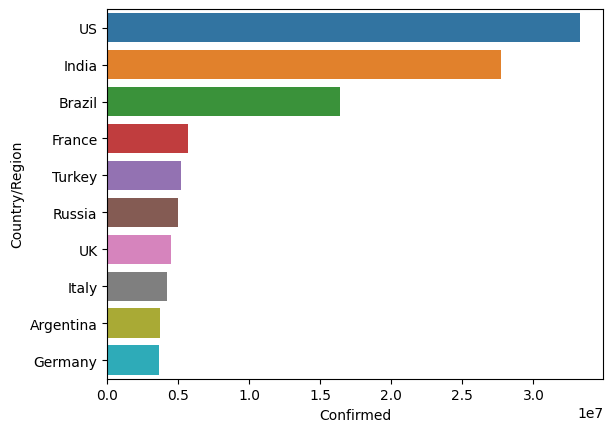

In [26]:
import seaborn as sns

data = top_10.collect().fetch().to_pandas()

sns.barplot(x=data["Confirmed"], y=data["Country/Region"], data=data)

##Pie charts and waffle charts

Next, I will display patient outcomes globally as a pie chart. To do this, I first take the "total" RemoteLazyFrame instance I previously created and get the total recovered, deceased and active cases values as a percetage of confirmed cases.

While we previously converted our dataframe to a Pandas dataframe to work with Seaborn functions, I will convert my dataframe to a NumPy array for compatability with matplotlib's pie function. This will provide me with the following 3d array: [[62.92123256  2.07889416 34.99987328]], which is why I need to index into my array and specify that I want to build my pie chart using the [0] row in my array.


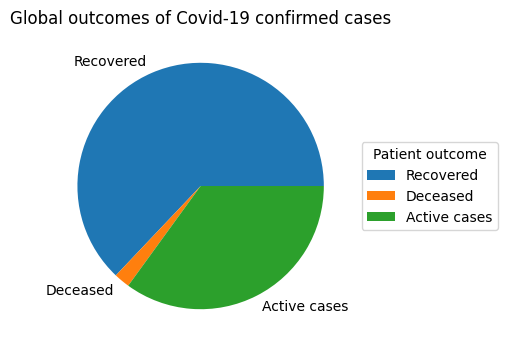

In [53]:
import matplotlib.pyplot as plt

pie_data = (
    total.select(
        pl.col(x) * 100 / pl.col("Confirmed")
        for x in ["Recovered", "Deaths", "Active_cases"]
    )
    .collect()
    .fetch()
)
fig, ax = plt.subplots(
    figsize=(7, 4), subplot_kw=dict(aspect="equal")
)  # define size of figure and get axis
wedges, autotexts = plt.pie(
    pie_data.to_numpy()[0], labels=["Recovered", "Deceased", "Active cases"]
)  # run plt.pie() and collect wedges output

ax.legend(
    wedges,
    ["Recovered", "Deceased", "Active cases"],  # create key with colour labels
    title="Patient outcome",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
)

ax.set_title("Global outcomes of Covid-19 confirmed cases")  # give pie chart a title
plt.show()  # display my pie chart

Now let's imagine we want to see the outcomes just for patients from France, Spain and Germany. Firstly I will filter down my by_country RemoteLazyFrame instance to only contain data relating to France, Germany and Spain and then I will collect().fetch() this dataframe.

In [28]:
compare = by_country.filter(
    (pl.col("Country/Region") == "France")
    | (pl.col("Country/Region") == "Germany")
    | (pl.col("Country/Region") == "Spain")
).sort(pl.col("Country/Region"))
compare.collect().fetch()

Country/Region,Deaths,Confirmed,Recovered,Active_cases
str,i64,i64,i64,i64
"""France""",109452,5708350,390196,5208702
"""Germany""",88360,3680159,3472650,119149
"""Spain""",79905,3668658,150376,3438377


Next, I will create a similar pie chart to previously, but I will compare the outcomes of France, Germany and Spain by creating a matplotlib figure with 3 subplots (1 row x 3 columns). I then iterate from 0 to 3, creating a pie chart for each country and labelling their axis accordingly.

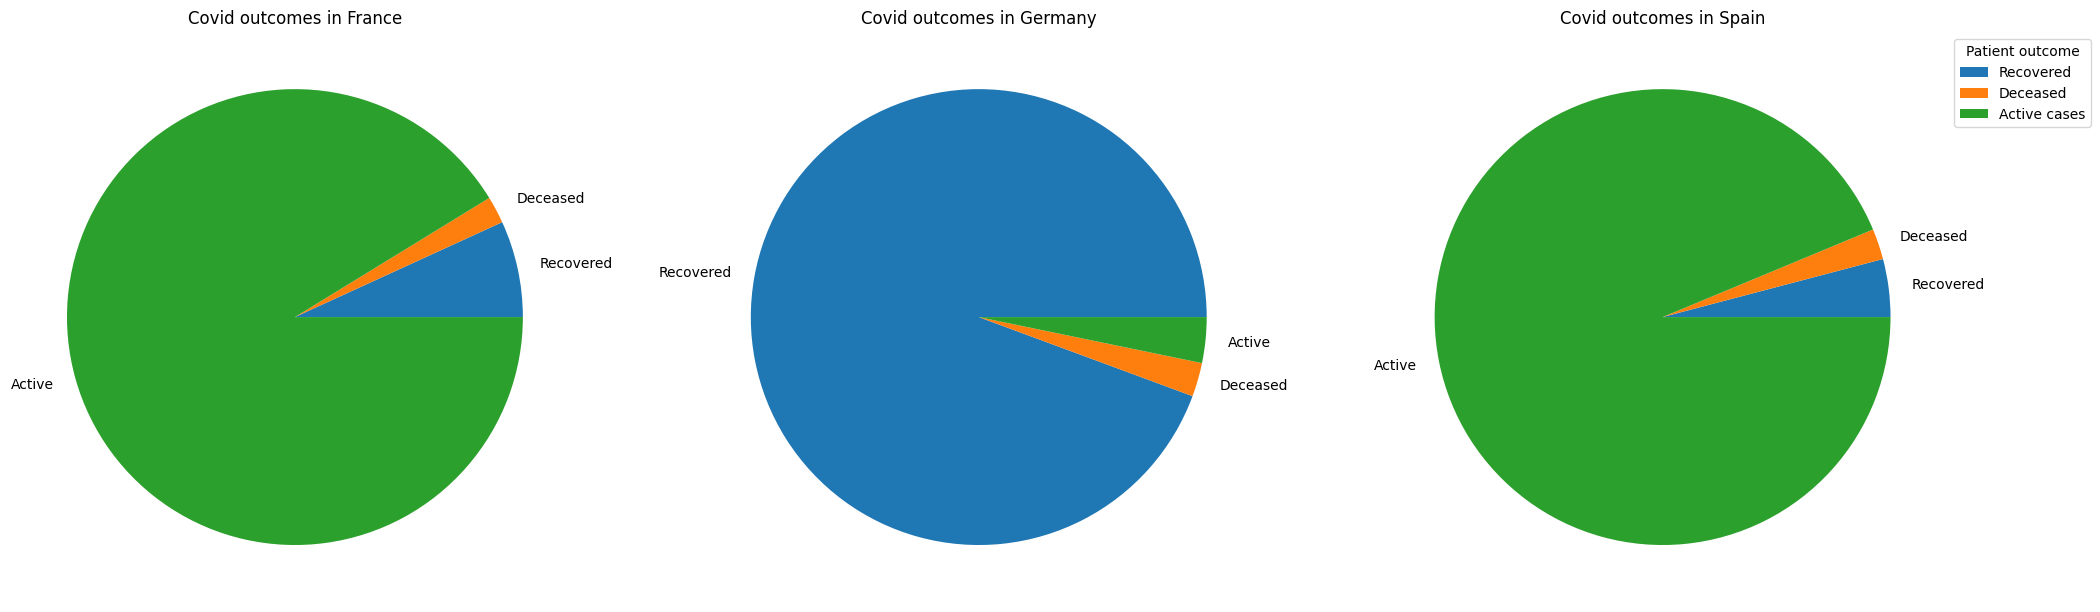

In [60]:
pie_data = compare.select(
    pl.col(x) * 100 / pl.col("Confirmed")
    for x in ["Recovered", "Deaths", "Active_cases"]
)

countries = ["France", "Germany", "Spain"]
fig, axes = plt.subplots(1, 3, figsize=(25, 20))

for i in range(3):
    wedges, autotexts = axes[i].pie(
        pie_data.collect().fetch().to_numpy()[i],
        labels=["Recovered", "Deceased", "Active"],
    )  # create pie charts
    axes[i].set_title("Covid outcomes in " + str(countries[i]))  # set title

axes[i].legend(
    wedges,
    ["Recovered", "Deceased", "Active cases"],  # create key with colour labels
    title="Patient outcome",
    loc="upper left",
    bbox_to_anchor=(1, 0, 0.5, 1),
)

Let's now take a look at confirmed cases by Province/State in Spain. We will create a fresh RemoteLazyFrame instance based on the original dataset to do this. I will first filter the data down to data released by Spain on the latest ObservationDate and then group data this time by Province/State before collecting the sum of confirmed cases.

In [90]:
all_cols = ["Confirmed", "Province/State"]

spain = (
    rdf.filter(
        (pl.col("Country/Region") == "Spain")
        & (pl.col("ObservationDate") == latest_date)
    )  # limit data to data shared by Spain on the latest observation date
    .select([pl.col(x) for x in all_cols])  # limit data to columns in all_cols list
    .groupby(pl.col("Province/State"))  # group data by province/state
    .agg(pl.col("Confirmed").sum())  # get the sum of confirmed cases
)
spain.collect().fetch()

Province/State,Confirmed
str,i64
"""Aragon""",123905
"""Madrid""",714616
"""Extremadura""",75693
"""Pais Vasco""",197812
"""Ceuta""",5829
"""Baleares""",60364
...,...
"""Navarra""",62232
"""Murcia""",112926


Now we have this data, we can make a donut chart displaying the percentage of cases in each region. To do this, I will simply create a pie chart as previously and then add a white circle over my pie chart to create a donut effect.

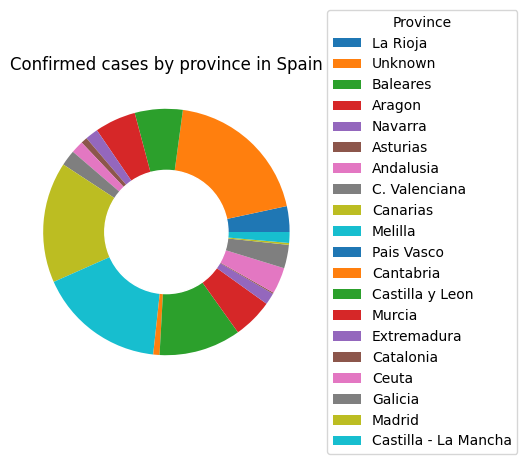

In [71]:
# get confirmed cases per region as a percentage
pie_data = spain.select(
    [pl.col("Province/State"), pl.col("Confirmed") * 100 / pl.col("Confirmed").sum()]
)

# get data and label values as NumPy arrays
pie = (
    pie_data.select(pl.col("Confirmed"))
    .collect()
    .fetch()
    .to_pandas()["Confirmed"]
    .to_numpy()
)
labels = (
    pie_data.select(pl.col("Province/State"))
    .collect()
    .fetch()
    .to_pandas()["Province/State"]
    .to_numpy()
)

# set up figure/axis and call pie function
fig, ax = plt.subplots(figsize=(7, 4), subplot_kw=dict(aspect="equal"))
wedges, autotexts = plt.pie(pie)

# create key with color labels
ax.legend(
    wedges, labels, title="Province", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)
)

ax.set_title("Confirmed cases by province in Spain")  # set title
my_circle = plt.Circle((0, 0), 0.5, color="white")  # create a white circle

# Get current pie chart figure using gcf() function and add white circle to it
fig = plt.gcf()
fig.gca().add_artist(my_circle)

# Display donut
plt.show()

For the next example, we will create a waffle chart of confirmed Covid cases by region in belgium. We will start off by performating the same query we did to get cases per regions in Spain, but , of course, for Belgium.

In [74]:
import seaborn as sns

all_cols = ["Confirmed", "Province/State"]

belgium = (
    rdf.filter(
        (pl.col("Country/Region") == "Belgium")
        & (pl.col("ObservationDate") == "2021-05-28")
    )  # limit data to data shared by Belgium on the latest observation date
    .select([pl.col(x) for x in all_cols])  # limit data to columns in all_cols list
    .groupby(pl.col("Province/State"))  # group data by province/state
    .agg([pl.col("Confirmed").sum()])  # get the sum of confirmed cases
)

square = (
    belgium.select(
        [
            pl.col("Province/State"),
            pl.col("Confirmed") * 100 / pl.col("Confirmed").sum(),
        ]
    )
    .collect()
    .fetch()
)

Next, I use squarify 

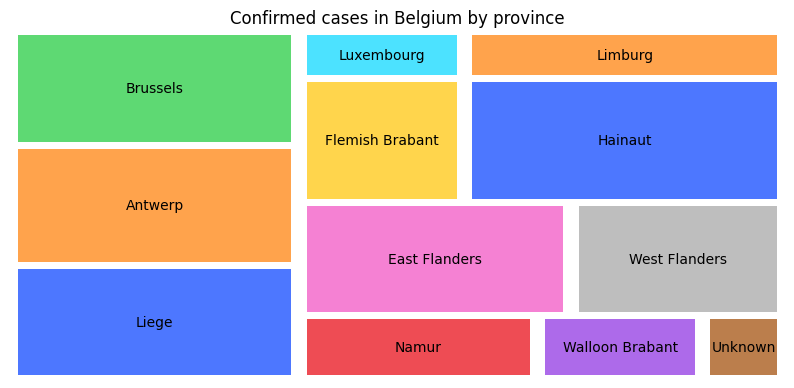

In [83]:
import squarify

# get series with percentage sizes of cases per region
sizes = square["Confirmed"]

# get series with labels for these percentages
label = square["Province/State"]

# create figure and define size
fig = plt.gcf()
fig.set_size_inches(10, 4.5)

# use squarify plot to create waffle chart
squarify.plot(
    sizes=sizes,
    label=label,
    alpha=0.7,
    color=sns.color_palette("bright"),
    pad=2,
    text_kwargs={"fontsize": 10},
).set(title="Confirmed cases in Belgium by province")

# disable x/y graph axis in output
plt.axis("off")

# display waffle chart
plt.show()

## Over time barchart
Finally, we can have a look at the evolution of confirmed covid cases over time. Let's take the UK as our example this time.

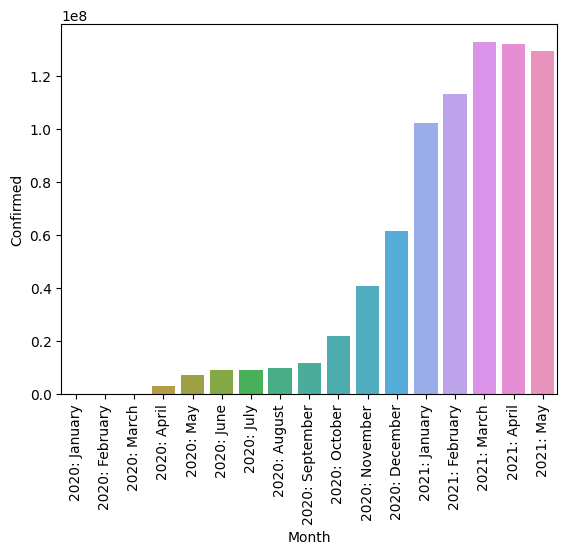

In [86]:
# get UK only dataframe
UK = rdf.filter((pl.col("Country/Region") == "UK")).collect().fetch()

# create a custom python dict to order months correctly
custom_dict = {
    "2020: January": 0,
    "2020: February": 1,
    "2020: March": 2,
    "2020: April": 3,
    "2020: May": 4,
    "2020: June": 5,
    "2020: July": 6,
    "2020: August": 7,
    "2020: September": 8,
    "2020: October": 9,
    "2020: November": 10,
    "2020: December": 11,
    "2021: January": 12,
    "2021: February": 13,
    "2021: March": 14,
    "2021: April": 15,
    "2021: May": 16,
}

UK = (
    UK.with_column(
        pl.when(pl.col("ObservationDate").dt.year() == 2020)
        .then(
            "2020: " + pl.col("ObservationDate").dt.strftime("%B")
        )  # replace 2020--mm--dd values with '2020: month'
        .otherwise(
            "2021: " + pl.col("ObservationDate").dt.strftime("%B")
        )  # replace 2021--mm--dd values with '2021: month'
        .alias("Month")  # store this column in 'Month column'
    )
    .groupby("Month")  # group by this column
    .agg(pl.col("Confirmed").sum())  # get Confirmed cases for the UK by month
)

# sort values using custom dict to order dates correctly despite using the string representation of month
UK = UK.to_pandas().sort_values(by=["Month"], key=lambda x: x.map(custom_dict))

# create barplot
sns.barplot(data=UK, x="Month", y="Confirmed")

# Rotates X-Axis labels by 90 degrees
plt.xticks(rotation=90)

# show bar chart
plt.show()

So that brings our demo to an end. All that's left to do is close our connection!

In [ ]:
connection.close()